In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from typing import Dict, Union
from pathlib import Path
from ipywidgets import interact
from scipy.optimize import curve_fit
from library import load_from_counting, replace_errbar

from ompy import NormalizerNLD, Vector
from ompy.normalizer_nld import load_levels_smooth

In [3]:
class LabeledVector(Vector):
    """ Convinience storage Vectors (gsf, nld) including plotting arguments """
    def __init__(self, fname: Union[str, Path] = None,
                 kwargs_plot: Dict = None, 
                 vector: Vector = None, *args, **kwargs):
        kwargs.setdefault("values", []) # a little hacky to prevent integrity error in om.Vector
        kwargs.setdefault("E", []) # a little hacky to prevent integrity error in om.Vector
        super(LabeledVector, self).__init__(*args, **kwargs)
        
        self.fname = fname  # path to file
        self.kwargs_plot = kwargs_plot  # additional kwargs for plotting, like label, alpha
        
        # if a Vector is provided, copy attributes from it
        if vector is not None:
            self.__dict__.update(vector.__dict__)
        
def updateVec(vec: Vector, arr: np.ndarray, units="MeV") -> Vector:
    """ update Vector from np.ndarray with collumns [E, value, std]"""
    vec.E = arr[:, 0]
    vec.values = arr[:, 1]
    vec.std = arr[:, 2]
    vec.units = units

read all nld and gsf files for plotting

In [4]:
# check that at least these item will be provided
# required_keys for gsf: ["oslo-raw", "shape"]
# otherwise can add as many as you like

gsfs = {}
gsf = LabeledVector(fname="data/shape-gsf.txt",
                    kwargs_plot={"label": "shape",
                                 "alpha": 0.7})
gsfs["shape"] = gsf

gsf = LabeledVector(fname="data/gsf_76Ge_EB2009.txt",
                    kwargs_plot={"label": "oslo-standard",
                                 "alpha": 0.3})
gsfs["oslo-std"] = gsf

gsf = LabeledVector(fname="data/Ge76_Mathis.txt",
                    kwargs_plot={"label": "Mathis",
                                 "alpha": 0.3})
gsfs["ext"] = gsf

nlds = {}
nld = LabeledVector(fname="data/leveldensity_76Ge_EB2009.txt",
                    kwargs_plot={"label": "oslo-standard",
                                 "alpha": 0.3})
nlds["oslo-std"] = nld

In [5]:
# Standard oslo
# Format: # ch, E, y, yerr; so we only read cols 1, 2 & 3,
#  - discard "dummy" data where nld/gsf is <= 0
#  - is in MeV
data = np.loadtxt(nlds["oslo-std"].fname, usecols=(1, 2, 3))
data = data[data[:, 1] > 0]
updateVec(nlds["oslo-std"], data)

data = np.loadtxt(gsfs["oslo-std"].fname, usecols=(1, 2, 3))
data = data[data[:, 1] > 0]
updateVec(gsfs["oslo-std"], data)

In [6]:
# load discrete levels with same binning as std oslo
levels = load_levels_smooth(
    path="data/levels_keV.dat", energy=nlds["oslo-std"].E, resolution=0.001)

In [7]:
# shape data
# Format: # x yhigh ylow
#  - convert to MeV
#  - draw as avg + std
data = np.loadtxt(gsfs["shape"].fname)
E = data[:, 0] / 1e3
mean = (data[:, 1] + data[:, 2]) / 2
std = data[:, 1] - mean

gsfs["shape"].E = E
gsfs["shape"].values = mean
gsfs["shape"].std = std
gsfs["shape"].units = "MeV"

In [8]:
# Mathis data
# Format: # x y xerr yerr; for now, discard xerr; read cols 0, 1 & 3,
#  - sort by Eg
#  - convert to MeV
data = np.loadtxt(gsfs["ext"].fname, usecols=(0, 1, 3))
data = np.sort(data, axis=0)
data[:, 0] /= 1e3
updateVec(gsfs["ext"], data)

<IPython.core.display.Javascript object>


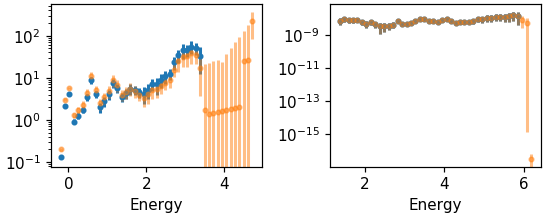

In [9]:
# Oslo "raw" data, so "raw" as in given a single normalization, not
# an error band
nld, gsf = load_from_counting(basefolder="data")

fig, axes = plt.subplots(1, 2, figsize=(5, 2), constrained_layout=True)
ax = axes[0]
nlds["oslo-std"].plot(ax=ax)
nld.plot(ax=ax, scale="log", alpha=0.5)

ax = axes[1]
gsfs["oslo-std"].plot(ax=ax)
gsf.plot(ax=ax, scale="log", alpha=0.5)

# cut away the higher part of the nld_raw and gsf_raw, as this was done in the original analysis
# or reading of the format was wrong?
nld.cut(Emax=nlds["oslo-std"].E[-1])
gsf.cut(Emax=gsfs["oslo-std"].E[-1])

nlds["oslo-raw"] = LabeledVector(vector=nld,
                                 kwargs_plot={"label": "oslo-raw",
                                              "alpha": 0.5})
gsfs["oslo-raw"] = LabeledVector(vector=gsf,
                                 kwargs_plot={"label": "oslo-raw",
                                              "alpha": 0.5})

In [10]:
# other parameters
Sn = 9.427  # MeV

# convenience def
nldCT = NormalizerNLD.const_temperature

# CT fit
xmin_CT = 2.0
xmax_CT = 3.0
def fitCT(nld, xmin_fit=xmin_CT, xmax_fit=xmax_CT):
    fit = nld.copy()
    fit.cut(Emin=xmin_fit, Emax=xmax_fit)
    return curve_fit(nldCT, fit.E, fit.values, sigma=fit.std)

In [11]:
def shape_base_plot(nlds, gsfs, levels):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    (ax1, ax2) = ax

    levels.plot(ax=ax1, kind="step", color="k",
                label="discrete levels (binned)", lw=1)

    nlds["oslo-std"].plot(ax=ax1, **nlds["oslo-std"].kwargs_plot)

    # gsf
    for _, gsf in gsfs.items():
        gsf.plot(ax=ax2, **gsf.kwargs_plot)
    return fig, ax

<IPython.core.display.Javascript object>


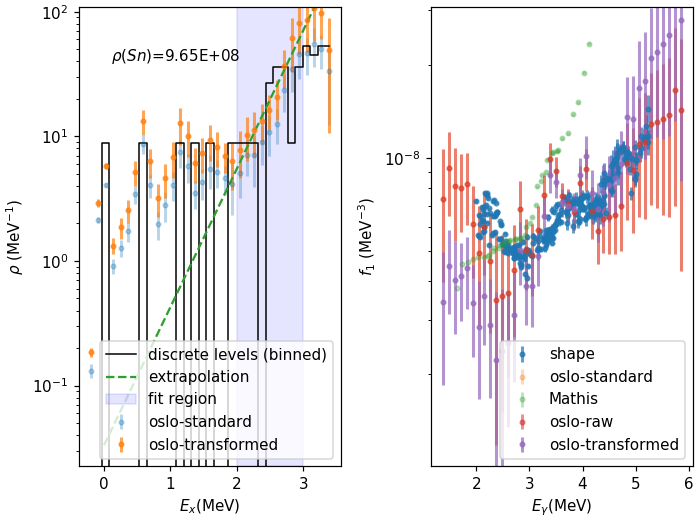

interactive(children=(FloatSlider(value=1.0, description='A', max=5.0), FloatSlider(value=0.3, description='B'…

<function __main__.update(A=1, B=0.3, alpha=0.32, xmin_CT=2.0, xmax_CT=3.0)>

In [12]:
# plot but without "oslo-raw"
fig, (ax1, ax2) = shape_base_plot(nlds, gsfs, levels)

# initial plot
nld = nlds["oslo-raw"].copy()
nld.plot(ax=ax1, label=r"oslo-transformed", alpha=0.7)
nld_line = ax1.lines[-1]
nld_collections = ax1.collections[-1]

gsf = gsfs["oslo-raw"].copy()
gsf.plot(ax=ax2, label=r"oslo-transformed", alpha=0.7)
gsf_line = ax2.lines[-1]
gsf_collections = ax2.collections[-1]

# initial CT guess + write nld(Sn) on axis
popt, pcov = fitCT(nld)
shade_fit = ax1.axvspan(xmin_CT, xmax_CT, alpha=0.1, color='blue',
                        label="fit region")
x = np.linspace(0, nld.E[-1])

line_fit, = ax1.plot(x, nldCT(x, *popt), "--",
                     label="extrapolation")
text = r"$\rho(Sn)$={:.2E}".format(nldCT(Sn, *popt))
text_fit = ax1.text(0.1, 40, text)

# plot the transformed values


def update(A=1, B=0.3, alpha=0.32, xmin_CT=xmin_CT, xmax_CT=xmax_CT):
    # transform nld
    nld = nlds["oslo-raw"].transform(const=A, alpha=alpha, inplace=False)
    nld_line.set_ydata(nld.values)
    errbar = nld_collections
    replace_errbar(errbar, lower=nld.values-nld.std,
                   upper=nld.values+nld.std)

    # transform gsf
    gsf = gsfs["oslo-raw"].transform(const=B, alpha=alpha, inplace=False)
    gsf_line.set_ydata(gsf.values)
    errbar = gsf_collections
    replace_errbar(errbar, lower=gsf.values-gsf.std,
                   upper=gsf.values+gsf.std)

    # redo CT fit
    popt, pcov = fitCT(nld, xmin_CT, xmax_CT)
    line_fit.set_ydata(nldCT(x, *popt))
    text = r"$\rho(Sn)$={:.2E}".format(nldCT(Sn, *popt))
    text_fit.set_text(text)
    shade_fit.set_xy([[xmin_CT, 0.], [xmin_CT, 1.],
                      [xmax_CT, 1.], [xmax_CT, 0.], [xmin_CT, 0.]])


# # beautify
ax1.legend(loc="best")
ax2.legend(loc="best")

yscale = "log"
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")
ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

interact(update, A=(0, 5, 0.1), B=(0, 5, 0.1), alpha=(-1, 1, 0.01))

<IPython.core.display.Javascript object>


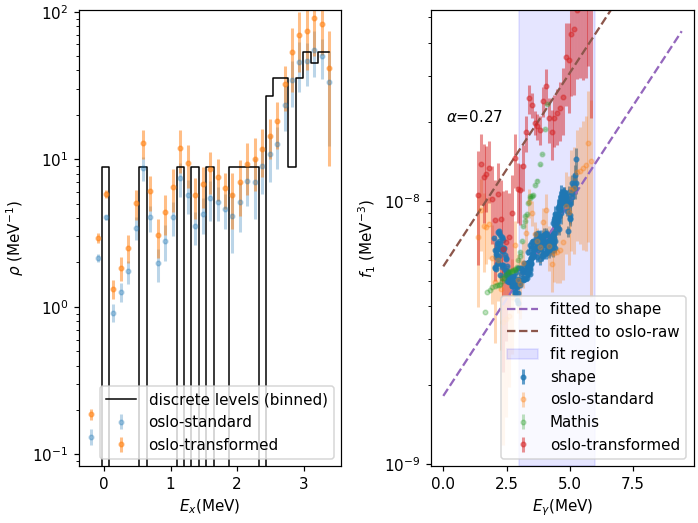

interactive(children=(FloatSlider(value=1.0, description='A', max=5.0), FloatSlider(value=1.0, description='B'…

<function __main__.update(A=1, B=1, xmin_lnlin=3.0, xmax_lnlin=6.0)>

In [13]:
# plot but without "oslo-raw"
nlds_ = copy.deepcopy(nlds)
gsfs_ = copy.deepcopy(gsfs)
nlds_.pop("oslo-raw")
gsfs_.pop("oslo-raw")
fig, (ax1, ax2) = shape_base_plot(nlds_, gsfs_, levels)

xmin_lnlin, xmax_lnlin = 3., 6.

def fitfun(x, a, c):
    return c*np.exp(x*a)

def fitgsf(gsf, xmin=xmin_lnlin, xmax=xmax_lnlin):
    fit = gsf.copy()
    fit.cut(Emin=xmin, Emax=xmax)
    return curve_fit(fitfun, fit.E, fit.values, sigma=fit.std)

# initial plot
nld = nlds["oslo-raw"].copy()
nld.plot(ax=ax1, label=r"oslo-transformed", alpha=0.5)
nld_line1 = ax1.lines[-1]
nld_collections1 = ax1.collections[-1]

gsf = gsfs["oslo-raw"].copy()
gsf.plot(ax=ax2, label=r"oslo-transformed", alpha=0.5)
gsf_line1 = ax2.lines[-1]
gsf_collections1 = ax2.collections[-1]

popt_shape, _ = fitgsf(gsfs["shape"])
x = np.linspace(0, Sn)
line_shape, = ax2.plot(x, fitfun(x, *popt_shape), "--",
                     label="fitted to shape")
shade_fit = ax2.axvspan(xmin_lnlin, xmax_lnlin, alpha=0.1, color='blue',
                        label="fit region")

popt_raw, _ = fitgsf(gsfs["oslo-raw"])
x = np.linspace(0, Sn)
line_raw, = ax2.plot(x, fitfun(x, *popt_raw), "--",
                     label="fitted to oslo-raw")

alpha = popt_shape[0]  - popt_raw[0]
text = rf"$\alpha$={alpha:.2f}"
text_fit1 = ax2.text(0.1, 2e-8, text)


def update(A=1, B=1, xmin_lnlin=xmin_lnlin, xmax_lnlin=xmax_lnlin):
    # transform nld
    popt_shape, _ = fitgsf(gsfs["shape"], xmin=xmin_lnlin, xmax=xmax_lnlin)  
    popt_raw, _ = fitgsf(gsfs["oslo-raw"], xmin=xmin_lnlin, xmax=xmax_lnlin)
    line_shape.set_ydata(fitfun(x, *popt_shape))
    shade_fit.set_xy([[xmin_lnlin, 0.], [xmin_lnlin, 1.],
                      [xmax_lnlin, 1.], [xmax_lnlin, 0.], [xmin_lnlin, 0.]])
 
    alpha = popt_shape[0]  - popt_raw[0]
    nld = nlds["oslo-raw"].transform(const=A, alpha=alpha, inplace=False)
    nld_line1.set_ydata(nld.values)
    errbar = nld_collections1
    replace_errbar(errbar, lower=nld.values-nld.std,
                   upper=nld.values+nld.std)
    
    # transform gsf
    gsf = gsfs["oslo-raw"].transform(const=B, alpha=alpha, inplace=False)
    gsf_line1.set_ydata(gsf.values)
    errbar = gsf_collections1
    replace_errbar(errbar, lower=gsf.values-gsf.std,
                   upper=gsf.values+gsf.std)
    # redo fit (with given B) 
    popt, _ = fitgsf(gsf, xmin=xmin_lnlin, xmax=xmax_lnlin)  
    line_raw.set_ydata(fitfun(x, *popt))
    text = rf"$\alpha$={alpha:.2f}"
    text_fit1.set_text(text)


# beautify
ax1.legend(loc="best")
ax2.legend(loc="best")

yscale = "log"
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")
ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

interact(update, A=(0, 5, 0.1), B=(0, 5, 0.1))